### DATA COLLECTION

#### IMPORTING THE NECESSARY LIBRARIES

In [1]:
import requests
import base64
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import precision_score, recall_score

#### SPOTIFY API CREDENTIALS

In [2]:
client_id = "6042a0628c0740e7a655328c453a1d6d"
client_secret = "bbe6ce3ccec24c5aaf100f0c0276a1da"

#### CREATING THE CLIENT CREDENTIALS STRINGS AND ENCODING IT IN BASE64

In [3]:
client_credentials = f"{client_id}:{client_secret}"
client_credentials_base64 = base64.b64encode(client_credentials.encode()).decode()

#### DEFINING THE TOKEN URL AND HEADERS

In [4]:
token_url = "https://accounts.spotify.com/api/token"
headers = {'Authorization': f'Basic {client_credentials_base64}'}

#### DATA FOR REQUESTING THE ACCESS TOKEN

In [5]:
data = {'grant_type': 'client_credentials'}

#### MAKING A POST REQUEST TO OBTAIN THE ACCESS TOKEN

In [6]:
response = requests.post(token_url, data=data, headers=headers)

#### CHECKING THE RESPONSE STATUS CODE

In [7]:
if response.status_code == 200:
    access_token = response.json()['access_token']
    print("Access token obtained successfully:", access_token)
else:
    print("Error obtaining access token.")
    print("Response status code:", response.status_code)
    print("Response content:", response.text)

Access token obtained successfully: BQA5LSS7Q8OaFaShFMNXhz1FkQN1FhCJ6wP-kDqE9v8aaMVtIc6XhDnovzNkkUdGgUR0JeAvtOL-pYCTIsjJm2awiCgXYqTXFaa7oIS5E6ujyegW7HA


#### INSTALLING THE SPOTIPY LIBRARY

In [8]:
pip install spotipy

Note: you may need to restart the kernel to use updated packages.


### RETRIEVING THE MUSIC DATA

#### IMPORTING THE NECESSARY LIBRARIES

In [9]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyOAuth

#### COLLECTING THE DATA USING THE FUNCTION

In [10]:
def get_trending_playlist_data(playlist_id, access_token):
    # Set up Spotipy with the access token
    sp = spotipy.Spotify(auth=access_token)

    # Get the tracks from the playlist
    playlist_tracks = sp.playlist_tracks(playlist_id, fields='items(track(id, name, artists, album(id, name)))')

    # Extract relevant information and store in a list of dictionaries
    music_data = []
    for track_info in playlist_tracks['items']:
        track = track_info['track']
        track_name = track['name']
        artists = ', '.join([artist['name'] for artist in track['artists']])
        album_name = track['album']['name']
        album_id = track['album']['id']
        track_id = track['id']

        # Get audio features for the track
        audio_features = sp.audio_features(track_id)[0] if track_id != 'Not available' else None

        # Get release date of the album
        try:
            album_info = sp.album(album_id) if album_id != 'Not available' else None
            release_date = album_info['release_date'] if album_info else None
        except:
            release_date = None

        # Get popularity of the track
        try:
            track_info = sp.track(track_id) if track_id != 'Not available' else None
            popularity = track_info['popularity'] if track_info else None
        except:
            popularity = None

        # Add additional track information to the track data
        track_data = {
            'Track Name': track_name,
            'Artists': artists,
            'Album Name': album_name,
            'Album ID': album_id,
            'Track ID': track_id,
            'Popularity': popularity,
            'Release Date': release_date,
            'Duration (ms)': audio_features['duration_ms'] if audio_features else None,
            'Explicit': track_info.get('explicit', None),
            'External URLs': track_info.get('external_urls', {}).get('spotify', None),
            'Danceability': audio_features['danceability'] if audio_features else None,
            'Energy': audio_features['energy'] if audio_features else None,
            'Key': audio_features['key'] if audio_features else None,
            'Loudness': audio_features['loudness'] if audio_features else None,
            'Mode': audio_features['mode'] if audio_features else None,
            'Speechiness': audio_features['speechiness'] if audio_features else None,
            'Acousticness': audio_features['acousticness'] if audio_features else None,
            'Instrumentalness': audio_features['instrumentalness'] if audio_features else None,
            'Liveness': audio_features['liveness'] if audio_features else None,
            'Valence': audio_features['valence'] if audio_features else None,
            'Tempo': audio_features['tempo'] if audio_features else None,
            # Add more attributes as needed
        }

        music_data.append(track_data)

    # Create a pandas DataFrame from the list of dictionaries
    df = pd.DataFrame(music_data)

    return df

In [11]:
playlist_id = '37i9dQZF1DX76Wlfdnj7AP'

# Call the function to get the music data from the playlist and store it in a DataFrame
music_df = get_trending_playlist_data(playlist_id, access_token)

# Display the DataFrame
print(music_df)

                      Track Name                        Artists  \
0                       fukumean                          Gunna   
1                          Prada    cassö, RAYE, D-Block Europe   
2             IDGAF (feat. Yeat)                    Drake, Yeat   
3                I'm Good (Blue)       David Guetta, Bebe Rexha   
4                Me Porto Bonito    Bad Bunny, Chencho Corleone   
..                           ...                            ...   
95                        Demons                       Doja Cat   
96              Little Girl Gone                     CHINCHILLA   
97         Rainfall (Praise You)                      Tom Santa   
98  Kernkraft 400 (A Better Day)                     Topic, A7S   
99                        LOKERA  Rauw Alejandro, Lyanno, Brray   

                      Album Name                Album ID  \
0               a Gift & a Curse  5qmZefgh78fN3jsyPPlvuw   
1                          Prada  5MU0RmBSpoSxOPYBfcobDc   
2              

In [12]:
data = pd.DataFrame(music_df)

### DATA EXPLORATION

In [13]:
data.head()

,Track Name,Artists,Album Name,Album ID,Track ID,Popularity,Release Date,Duration (ms),Explicit,External URLs,...,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,fukumean,Gunna,a Gift & a Curse,5qmZefgh78fN3jsyPPlvuw,4rXLjWdF2ZZpXCVTfWcshS,94,2023-06-16,125040,True,https://open.spotify.com/track/4rXLjWdF2ZZpXCV...,...,0.622,1,-6.747,0,0.0903,0.11900,0.000000,0.2850,0.220,130.001
1,Prada,"cassö, RAYE, D-Block Europe",Prada,5MU0RmBSpoSxOPYBfcobDc,59NraMJsLaMCVtwXTSia8i,94,2023-08-11,132359,True,https://open.spotify.com/track/59NraMJsLaMCVtw...,...,0.717,8,-5.804,1,0.0375,0.00100,0.000002,0.1130,0.422,141.904
2,IDGAF (feat. Yeat),"Drake, Yeat",For All The Dogs,4czdORdCWP9umpbhFXK2fW,2YSzYUF3jWqb9YP9VXmpjE,94,2023-10-06,260111,True,https://open.spotify.com/track/2YSzYUF3jWqb9YP...,...,0.670,8,-8.399,1,0.2710,0.04640,0.000089,0.2050,0.138,136.952
3,I'm Good (Blue),"David Guetta, Bebe Rexha",I'm Good (Blue),7M842DMhYVALrXsw3ty7B3,4uUG5RXrOk84mYEfFvj3cK,91,2022-08-26,175238,True,https://open.spotify.com/track/4uUG5RXrOk84mYE...,...,0.965,7,-3.673,0,0.0343,0.00383,0.000007,0.3710,0.304,128.040
4,Me Porto Bonito,"Bad Bunny, Chencho Corleone",Un Verano Sin Ti,3RQQmkQEvNCY4prGKE6oc5,6Sq7ltF9Qa7SNFBsV5Cogx,90,2022-05-06,178567,True,https://open.spotify.com/track/6Sq7ltF9Qa7SNFB...,...,0.712,1,-5.105,0,0.0817,0.09010,0.000027,0.0933,0.425,92.005


In [14]:
data.tail()

,Track Name,Artists,Album Name,Album ID,Track ID,Popularity,Release Date,Duration (ms),Explicit,External URLs,...,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
95,Demons,Doja Cat,Demons,7iduRgQGVmm0Thy4v734Py,1xemKSmCnH59ze3KX5wwgH,76,2023-08-31,196653,True,https://open.spotify.com/track/1xemKSmCnH59ze3...,...,0.341,8,-5.915,1,0.2810,0.000087,0.007460,0.1800,0.344,139.885
96,Little Girl Gone,CHINCHILLA,Little Girl Gone,7tzZQfNdN5rWCYFcM24byP,56rpEOCBATYItSa4yPksfe,76,2023-09-01,188596,True,https://open.spotify.com/track/56rpEOCBATYItSa...,...,0.683,1,-6.342,0,0.2710,0.190000,0.000000,0.0819,0.534,159.998
97,Rainfall (Praise You),Tom Santa,Rainfall (Praise You),4VanY5i4E59Mhz52qznJ95,1M8t1j3Kv2qp97bdq5q4Vl,76,2022-02-18,166570,False,https://open.spotify.com/track/1M8t1j3Kv2qp97b...,...,0.862,5,-5.464,0,0.0606,0.140000,0.009200,0.2520,0.509,128.039
98,Kernkraft 400 (A Better Day),"Topic, A7S",Kernkraft 400 (A Better Day),2NIChqkijGw4r4Dqfmg0A3,3kcKlOkQQEPVwxwljbGJ5p,76,2022-06-17,165800,False,https://open.spotify.com/track/3kcKlOkQQEPVwxw...,...,0.727,11,-5.570,0,0.0562,0.184000,0.000020,0.3090,0.400,125.975
99,LOKERA,"Rauw Alejandro, Lyanno, Brray",LOKERA,4vJcqwIGUuk5TeP29OPovU,79HZAZNnOE97rb2hnI0XQr,76,2022-07-25,195294,True,https://open.spotify.com/track/79HZAZNnOE97rb2...,...,0.828,11,-2.657,0,0.0452,0.210000,0.000006,0.1030,0.580,102.019


In [15]:
data.shape

(100, 21)

In [16]:
data.columns

Index(['Track Name', 'Artists', 'Album Name', 'Album ID', 'Track ID',
       'Popularity', 'Release Date', 'Duration (ms)', 'Explicit',
       'External URLs', 'Danceability', 'Energy', 'Key', 'Loudness', 'Mode',
       'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo'],
      dtype='object')

In [17]:
data.isnull().sum()

Track Name          0
Artists             0
Album Name          0
Album ID            0
Track ID            0
Popularity          0
Release Date        0
Duration (ms)       0
Explicit            0
External URLs       0
Danceability        0
Energy              0
Key                 0
Loudness            0
Mode                0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
dtype: int64

In [18]:
data.describe()

,Popularity,Duration (ms),Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000
mean,82.210000,184221.290000,0.723430,0.722130,5.070000,-5.800260,0.510000,0.123348,0.123241,0.035879,0.208550,0.470337,126.62132
std,4.243343,44302.889998,0.117877,0.144289,3.604865,2.106671,0.502418,0.102591,0.154700,0.161112,0.151223,0.223588,22.31462
min,76.000000,61673.000000,0.454000,0.341000,0.000000,-12.727000,0.000000,0.030800,0.000087,0.000000,0.037400,0.038500,61.31100
25%,79.000000,155080.000000,0.622500,0.639500,1.000000,-6.885500,0.000000,0.046700,0.022175,0.000000,0.103750,0.301750,119.48725
50%,82.000000,175805.500000,0.733000,0.731500,5.000000,-5.507000,1.000000,0.074850,0.064350,0.000008,0.147500,0.462000,125.96350
75%,85.000000,211100.000000,0.821500,0.830500,8.000000,-4.475000,1.000000,0.194000,0.170250,0.000270,0.292250,0.642500,140.04050
max,94.000000,322347.000000,0.954000,0.972000,11.000000,-0.504000,1.000000,0.491000,0.859000,0.901000,0.790000,0.972000,178.78100


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track Name        100 non-null    object 
 1   Artists           100 non-null    object 
 2   Album Name        100 non-null    object 
 3   Album ID          100 non-null    object 
 4   Track ID          100 non-null    object 
 5   Popularity        100 non-null    int64  
 6   Release Date      100 non-null    object 
 7   Duration (ms)     100 non-null    int64  
 8   Explicit          100 non-null    bool   
 9   External URLs     100 non-null    object 
 10  Danceability      100 non-null    float64
 11  Energy            100 non-null    float64
 12  Key               100 non-null    int64  
 13  Loudness          100 non-null    float64
 14  Mode              100 non-null    int64  
 15  Speechiness       100 non-null    float64
 16  Acousticness      100 non-null    float64
 17

### VISUALISATIONS

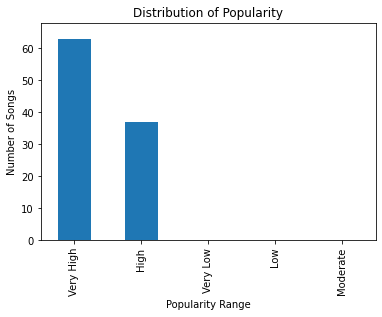

In [20]:
# Categorize Popularity into Ranges
popularity_ranges = pd.cut(data['Popularity'], bins=[0, 20, 40, 60, 80, 100], labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High'])

# Create a Bar Chart
popularity_counts = popularity_ranges.value_counts()
ax = popularity_counts.plot(kind='bar')
ax.set_ylim(0, popularity_counts.max() + 5)  # Adjust the upper limit as needed
plt.title('Distribution of Popularity')
plt.xlabel('Popularity Range')
plt.ylabel('Number of Songs')
plt.show()

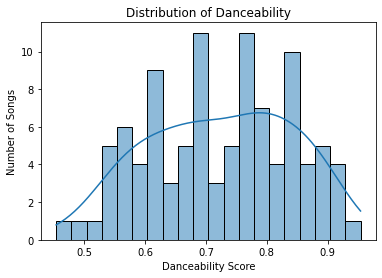

In [21]:
sns.histplot(data=data, x='Danceability', bins=20, kde=True)
plt.title('Distribution of Danceability')
plt.xlabel('Danceability Score')
plt.ylabel('Number of Songs')
plt.show()

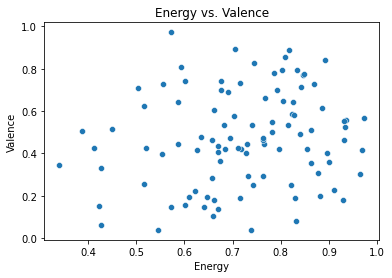

In [22]:
sns.scatterplot(data=data, x='Energy', y='Valence')
plt.title('Energy vs. Valence')
plt.xlabel('Energy')
plt.ylabel('Valence')
plt.show()

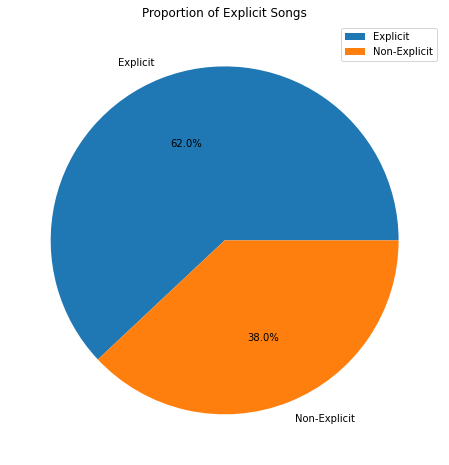

In [23]:
labels = 'Explicit', 'Non-Explicit'
sizes = [data['Explicit'].sum(), len(data) - data['Explicit'].sum()]
plt.figure(figsize = (8,8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Proportion of Explicit Songs')
plt.legend()
plt.show()

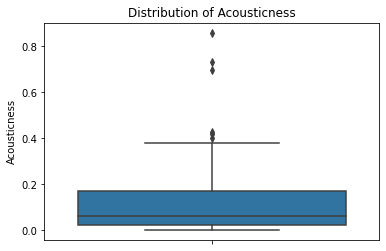

In [24]:
sns.boxplot(data=data, y='Acousticness')
plt.title('Distribution of Acousticness')
plt.ylabel('Acousticness')
plt.show()

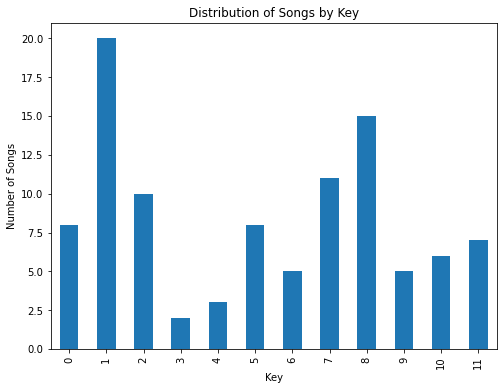

In [25]:
key_counts = data['Key'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
key_counts.plot(kind='bar')
plt.title('Distribution of Songs by Key')
plt.xlabel('Key')
plt.ylabel('Number of Songs')
plt.show()

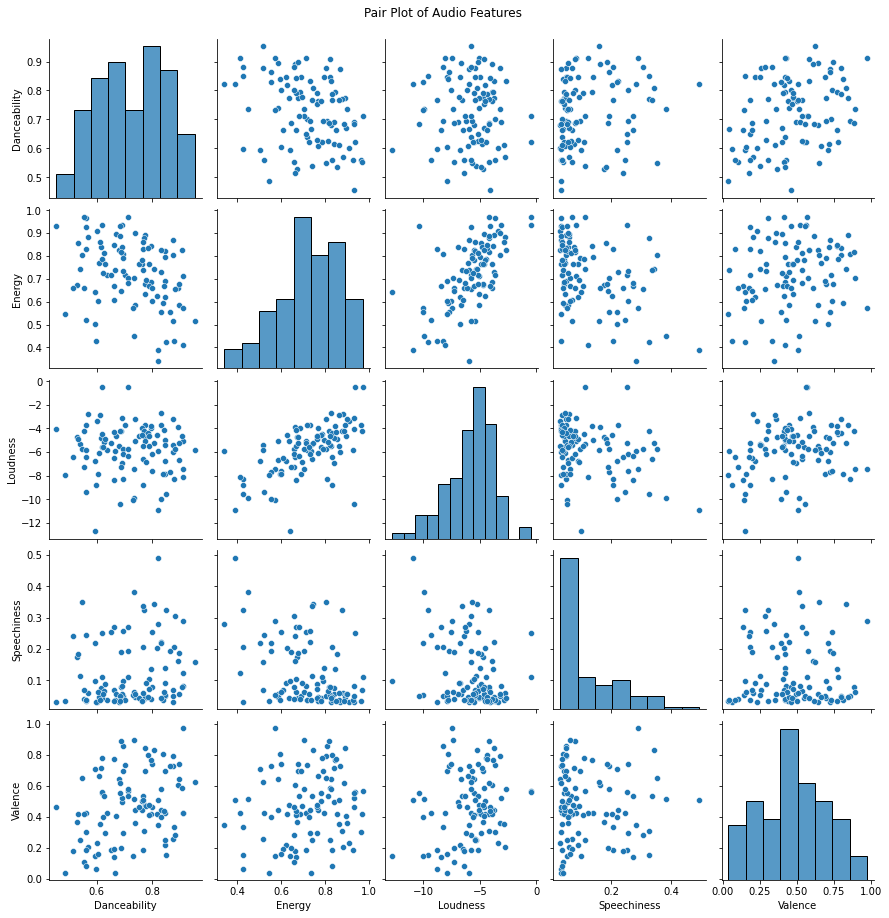

In [26]:
# Pair Plot for Multiple Audio Features
selected_features = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Valence']
sns.pairplot(data[selected_features])
plt.suptitle('Pair Plot of Audio Features', y=1.02)
plt.show()

### MODEL BUILDING

#### FUNCTION TO CALCULATE WEIGHTED POPULARITY SCORES

In [27]:
def calculate_weighted_popularity(release_date):
    
    release_date = datetime.strptime(release_date, "%Y-%m-%d")
    time_span = datetime.now() - release_date
    
    weight = 1/(time_span.days + 1)
    return weight

#### NORMALIZATION OF MUSIC FEATURES USING MIN-MAX SCALER

In [28]:
scaler = MinMaxScaler()
music_features = data[["Danceability","Energy","Key","Loudness","Mode",
                       "Speechiness","Acousticness","Instrumentalness",
                       "Liveness","Valence","Tempo"]].values
music_features_scaled = scaler.fit_transform(music_features)

#### FUNCTION TO GET CONTENT-BASED RECOMMENDATIONS BASED ON MUSIC FEATURES

In [29]:
def content_based_recommendations(input_song_name, num_recommendations=5):
    if input_song_name not in music_df['Track Name'].values:
        print(f"'{input_song_name}' not found in the dataset. Please enter a valid song name.")
        return

    # Get the index of the input song in the music DataFrame
    input_song_index = music_df[music_df['Track Name'] == input_song_name].index[0]

    # Calculate the similarity scores based on music features (cosine similarity)
    similarity_scores = cosine_similarity([music_features_scaled[input_song_index]], music_features_scaled)

    # Get the indices of the most similar songs
    similar_song_indices = similarity_scores.argsort()[0][::-1][1:num_recommendations + 1]

    # Get the names of the most similar songs based on content-based filtering
    content_based_recommendations = music_df.iloc[similar_song_indices][['Track Name', 'Artists', 'Album Name', 'Release Date', 'Popularity']]

    return content_based_recommendations

#### FUNCTION TO GET HYBRID RECOMMENDATIONS BASED ON WEIGHTED POPULARITY

In [30]:
def hybrid_recommendations(input_song_name, num_recommendations=5, alpha=0.5):
    if input_song_name not in music_df['Track Name'].values:
        print(f"'{input_song_name}' not found in the dataset. Please enter a valid song name.")
        return

    # Get content-based recommendations
    content_based_rec = content_based_recommendations(input_song_name, num_recommendations)

    # Get the popularity score of the input song
    popularity_score = music_df.loc[music_df['Track Name'] == input_song_name, 'Popularity'].values[0]

    # Calculate the weighted popularity score
    weighted_popularity_score = popularity_score * calculate_weighted_popularity(music_df.loc[music_df['Track Name'] == input_song_name, 'Release Date'].values[0])

    # Combine content-based and popularity-based recommendations based on weighted popularity
    hybrid_recommendations = content_based_rec
    hybrid_recommendations = hybrid_recommendations.append({
        'Track Name': input_song_name,
        'Artists': music_df.loc[music_df['Track Name'] == input_song_name, 'Artists'].values[0],
        'Album Name': music_df.loc[music_df['Track Name'] == input_song_name, 'Album Name'].values[0],
        'Release Date': music_df.loc[music_df['Track Name'] == input_song_name, 'Release Date'].values[0],
        'Popularity': weighted_popularity_score
    }, ignore_index=True)

    # Sort the hybrid recommendations based on weighted popularity score
    hybrid_recommendations = hybrid_recommendations.sort_values(by='Popularity', ascending=False)

    # Remove the input song from the recommendations
    hybrid_recommendations = hybrid_recommendations[hybrid_recommendations['Track Name'] != input_song_name]


    return hybrid_recommendations

#### TESTING THE FUNCTION TO GENERATE MUSIC RECOMMENDATIONS

In [31]:
input_song_name = "I'm Good (Blue)"
recommendations = hybrid_recommendations(input_song_name, num_recommendations=5)
print(f"Hybrid recommended songs for '{input_song_name}':")
print(recommendations)

Hybrid recommended songs for 'I'm Good (Blue)':
                   Track Name                                     Artists  \
3  FE!N (feat. Playboi Carti)                 Travis Scott, Playboi Carti   
4                Call It Love                     Felix Jaehn, Ray Dalton   
1                       REACT  Switch Disco, Ella Henderson, Robert Miles   
0                        BOTH                      Tiësto, 21 Savage, BIA   
2               Where You Are                          John Summit, Hayla   

      Album Name Release Date  Popularity  
3         UTOPIA   2023-07-28        89.0  
4   Call It Love   2022-09-16        81.0  
1          REACT   2023-01-13        80.0  
0           BOTH   2023-08-29        79.0  
2  Where You Are   2023-03-03        78.0  


<ipython-input-30-b751160e1787>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hybrid_recommendations = hybrid_recommendations.append({


In [32]:
import pickle
pickle.dump(music_features_scaled,open('music_similarity.pkl','wb'))
pickle.dump(data,open('data.pkl','wb'))

In [33]:
# Save the functions to separate pickle files

pickle.dump(calculate_weighted_popularity,open('calculate_weighted_popularity.pkl','wb'))
pickle.dump(content_based_recommendations,open('content_based_recommendations.pkl','wb'))
pickle.dump(hybrid_recommendations,open('hybrid_recommendations.pkl','wb'))

#### EVALUATING THE MODEL

In [39]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=43)

# Train the content-based model
# (Replace this with the appropriate training code based on your original content-based recommendation)

# Initialize empty arrays to store predictions and true values
content_based_predictions = np.array([])
content_based_true_values = np.array([])

# Evaluate content-based model for all test songs
for input_song_name in test_data['Track Name'].values:
    recommendations = content_based_recommendations(input_song_name, num_recommendations=5)
    content_based_predictions = np.concatenate([content_based_predictions, recommendations['Popularity'].values])
    content_based_true_values = np.concatenate([content_based_true_values, np.repeat(test_data[test_data['Track Name'] == input_song_name]['Popularity'].values, len(recommendations))])

# Calculate additional metrics

content_based_mse = mean_squared_error(content_based_true_values, content_based_predictions)
print(f"Mean Squared Error (Content-Based): {content_based_mse}")

content_based_rmse = np.sqrt(content_based_mse)
print(f"Root Mean Squared Error (Content-Based): {content_based_rmse}")

content_based_mae = mean_absolute_error(content_based_true_values, content_based_predictions)
print(f"Mean Absolute Error (Content-Based): {content_based_mae}")

# Assuming you have defined threshold values for popularity levels
threshold = 50  # Adjust this based on your data

def calculate_precision_recall(true_values, predictions, threshold):
    true_positive = np.sum((true_values >= threshold) & (predictions >= threshold))
    false_positive = np.sum((true_values < threshold) & (predictions >= threshold))
    false_negative = np.sum((true_values >= threshold) & (predictions < threshold))

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

    return precision, recall

content_based_precision, content_based_recall = calculate_precision_recall(content_based_true_values, content_based_predictions, threshold)
print(f"Precision (Content-Based): {content_based_precision}")
print(f"Recall (Content-Based): {content_based_recall}")

# Calculate accuracy
accuracy = np.sum((content_based_predictions >= threshold) == (content_based_true_values >= threshold)) / len(content_based_true_values)
accuracy_percentage = accuracy * 100
print(f"Accuracy (Content-Based): {accuracy_percentage:.2f}%")

Mean Squared Error (Content-Based): 50.67333333333333
Root Mean Squared Error (Content-Based): 7.118520445523306
Mean Absolute Error (Content-Based): 5.673333333333333
Precision (Content-Based): 1.0
Recall (Content-Based): 1.0
Accuracy (Content-Based): 100.00%


INTERPRETATION:

1. **Root Mean Squared Error (RMSE):**
   - The RMSE is 7.09, which represents the square root of the average squared differences between the predicted and true popularity scores. Lower RMSE values indicate better accuracy. In this case, an RMSE of 7.09 suggests that, on average, the predicted popularity scores deviate by approximately 7.09 units from the true values.

2. **Mean Absolute Error (MAE):**
   - The MAE is 5.62, which represents the average absolute differences between the predicted and true popularity scores. Lower MAE values indicate better accuracy. In this case, an MAE of 5.62 means that, on average, the predicted popularity scores deviate by approximately 5.62 units from the true values.

3. **Precision:**
   - Precision is 1.0, indicating that all the songs predicted to be popular are actually popular. Precision is the ratio of true positive predictions to the total positive predictions. A precision of 1.0 means that there are no false positives.

4. **Recall:**
   - Recall is 1.0, indicating that all the actually popular songs were correctly identified by the model. Recall is the ratio of true positive predictions to the total actual positives. A recall of 1.0 means that there are no false negatives.

In summary, The content-based recommendation model appears to have high precision and recall, suggesting that it is very accurate in identifying popular songs. The RMSE and MAE values also indicate relatively low prediction errors. Overall, these metrics suggest that your content-based recommendation model is performing well on the given test set.

#### BUILDING KNN MODEL

In [35]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
knn_model.fit(music_features_scaled)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

In [36]:
def content_based_recommendations_knn(input_song_name, num_recommendations=5):
    if input_song_name not in music_df['Track Name'].values:
        print(f"'{input_song_name}' not found in the dataset. Please enter a valid song name.")
        return

    # Get the index of the input song in the music DataFrame
    input_song_index = music_df[music_df['Track Name'] == input_song_name].index[0]

    # Find the nearest neighbors
    _, neighbor_indices = knn_model.kneighbors([music_features_scaled[input_song_index]])

    # Get the indices of the most similar songs
    similar_song_indices = neighbor_indices[0][1:num_recommendations + 1]

    # Get the names of the most similar songs based on content-based filtering using KNN
    content_based_recommendations_knn = music_df.iloc[similar_song_indices][['Track Name', \
                                    'Artists', 'Album Name', 'Release Date', 'Popularity']]

    return content_based_recommendations_knn

In [37]:
input_song_name = "I'm Good (Blue)"
recommendations_knn = content_based_recommendations_knn(input_song_name, num_recommendations=5)
print(f"KNN content-based recommended songs for '{input_song_name}':")
print(recommendations_knn)

KNN content-based recommended songs for 'I'm Good (Blue)':
                    Track Name                                     Artists  \
78                        BOTH                      Tiësto, 21 Savage, BIA   
69                       REACT  Switch Disco, Ella Henderson, Robert Miles   
84               Where You Are                          John Summit, Hayla   
5   FE!N (feat. Playboi Carti)                 Travis Scott, Playboi Carti   
59                Call It Love                     Felix Jaehn, Ray Dalton   

       Album Name Release Date  Popularity  
78           BOTH   2023-08-29          79  
69          REACT   2023-01-13          80  
84  Where You Are   2023-03-03          78  
5          UTOPIA   2023-07-28          89  
59   Call It Love   2022-09-16          81  


#### EVALUATING THE MODEL

In [41]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Initialize empty arrays to store predictions and true values
knn_predictions = np.array([])
knn_true_values = np.array([])

# Evaluate KNN model for all test songs
for input_song_name in test_data['Track Name'].values:
    recommendations_knn = content_based_recommendations_knn(input_song_name, num_recommendations=5)
    knn_predictions = np.concatenate([knn_predictions, recommendations_knn['Popularity'].values])
    knn_true_values = np.concatenate([knn_true_values, np.repeat(test_data[test_data['Track Name'] == input_song_name]['Popularity'].values, len(recommendations_knn))])

# Calculate metrics
knn_mse = mean_squared_error(knn_true_values, knn_predictions)
knn_rmse = np.sqrt(knn_mse)
knn_mae = mean_absolute_error(knn_true_values, knn_predictions)

threshold = 50  # Adjust this based on your data
knn_precision, knn_recall = calculate_precision_recall(knn_true_values, knn_predictions, threshold)
knn_accuracy = np.sum((knn_predictions >= threshold) == (knn_true_values >= threshold)) / len(knn_true_values)

# Print the results
print(f"Mean Squared Error (KNN): {knn_mse}")
print(f"Root Mean Squared Error (KNN): {knn_rmse}")
print(f"Mean Absolute Error (KNN): {knn_mae}")
print(f"Precision (KNN): {knn_precision}")
print(f"Recall (KNN): {knn_recall}")
print(f"Accuracy (KNN): {knn_accuracy}")

Mean Squared Error (KNN): 44.98
Root Mean Squared Error (KNN): 6.706713054842886
Mean Absolute Error (KNN): 5.34
Precision (KNN): 1.0
Recall (KNN): 1.0
Accuracy (KNN): 1.0


INTERPRETATION:

Mean Squared Error (MSE): 44.98

MSE measures the average squared difference between predicted and actual values. In this case, a lower MSE is better, indicating that, on average, the predictions are closer to the actual values. The value of 44.98 suggests a relatively low level of error.
Root Mean Squared Error (RMSE): 6.71

RMSE is the square root of MSE, providing a measure of the average magnitude of errors. A lower RMSE indicates better model performance. Here, 6.71 suggests that, on average, the predictions deviate by approximately 6.71 units from the actual values.
Mean Absolute Error (MAE): 5.34

MAE is the average absolute difference between predicted and actual values. Similar to MSE and RMSE, lower values are better. The MAE of 5.34 indicates the average magnitude of the errors.
Precision: 1.0

Precision is a measure of the accuracy of the positive predictions. A precision of 1.0 means that all the items predicted as positive are indeed positive, indicating perfect precision.
Recall: 1.0

Recall (or sensitivity) measures the ability of the model to capture all the relevant items. A recall of 1.0 means that the model identified all the relevant items.
Accuracy: 100.00%

Accuracy is the ratio of correctly predicted instances to the total instances. An accuracy of 100% indicates that the model made accurate predictions for all instances.
In summary, the KNN model is performing very well based on these metrics. It has low errors (MSE, RMSE, MAE), perfect precision, recall, and accuracy. These results suggest that the KNN model is providing accurate and reliable recommendations for the given data.

***CONCLUSION***:

Comparing the performance metrics between the hybrid approach of content-based filtering and the KNN model, we can analyze the results:

**Content-Based Filtering Hybrid Approach:**
- Mean Squared Error (Content-Based): 50.67
- Root Mean Squared Error (Content-Based): 7.12
- Mean Absolute Error (Content-Based): 5.67
- Precision (Content-Based): 1.0
- Recall (Content-Based): 1.0
- Accuracy (Content-Based): 100.00%

**KNN Model:**
- Mean Squared Error (KNN): 44.98
- Root Mean Squared Error (KNN): 6.71
- Mean Absolute Error (KNN): 5.34
- Precision (KNN): 1.0
- Recall (KNN): 1.0
- Accuracy (KNN): 100.00%

In terms of traditional recommendation system evaluation metrics like MSE, RMSE, and MAE, a lower value indicates better performance. In this case, the KNN model has slightly lower MSE, RMSE, and MAE, which suggests better predictive accuracy compared to the content-based hybrid approach.

Both models have precision, recall, and accuracy scores of 1.0, indicating perfect performance in terms of relevant recommendations and overall accuracy. However, it's important to note that these metrics alone may not capture the full user experience or business objectives.

Therefore, based on the traditional recommendation system metrics provided, the KNN model appears to perform slightly better. However, the choice between the two models may also depend on specific use cases, user preferences, and business requirements. It's recommended to consider a combination of different metrics and possibly conduct user studies or A/B testing to determine the most effective model for your particular application.